In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from loadmodules import *

In [2]:
simulation_list = ['Au6_lvl5_1b99_nokcfe_wmtrunc']
print(simulation_list)

['Au6_lvl5_1b99_nokcfe_wmtrunc']


In [3]:
def get_mass_functions(simulation, age_intermediate=6., age_old=10., inner_radius=0., outer_radius=100., plot_agedistribution=False):
    sf = load_subfind(127, dir=simulation+'/output/')
    s = gadget_readsnap(127, snappath=simulation+'/output/', subfind=sf, applytransformationfacs=True, hdf5=True, loadonlyhalo=0, loadonlytype=[4])

    s.calc_sf_indizes(sf)
    rot_matrix = s.select_halo(sf)

    s.data['pos'] *= 1e3 # in kpc
    s.data['mass'] *= 1e10 # change mass to solar masses
    s.data['mclt'] *= 1e10
    s.data['imcl'] *= 1e10

    s.data['r'] = np.sqrt(np.sum((s.data['pos'])**2, axis=1))

    mask_clusters_initial = (s.data['incl'] > 0 ) * (s.data['r']>inner_radius) * (s.data['r']<=outer_radius)
    
    cluster_masses = s.data['mclt'][mask_clusters_initial].flatten()
    init_cluster_masses = s.data['imcl'][mask_clusters_initial].flatten()
    
    not_empty_clusters = (init_cluster_masses>0)

    cluster_masses = cluster_masses[not_empty_clusters]
    init_cluster_masses = init_cluster_masses[not_empty_clusters]
    
    print('Maximum initial mass {:2.2e} Msun'.format(init_cluster_masses.max()))
    print('Maximum present-day mass {:2.2e} Msun'.format(cluster_masses.max()))

    disruption_time = s.data['drpt'][mask_clusters_initial].flatten()
    disruption_time = disruption_time[not_empty_clusters]

    clusters_formtime = []
    for i in range(len(s.data['incl'][mask_clusters_initial])):
        nclt = s.data['incl'][mask_clusters_initial][i]
        clusters_formtime.append(np.ones(nclt) * s.data['age'][mask_clusters_initial][i])

    clusters_formtime = np.concatenate(clusters_formtime)

    clusters_age = s.cosmology_get_lookback_time_from_a(clusters_formtime, is_flat=True)

    mask_problematic = s.data['imfc']>1
    print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
    print('That`s {:.3f}% of stars with clusters'.format(mask_problematic.sum()/mask_clusters_initial.sum() * 100))

    if plot_agedistribution:
        plt.hist(clusters_age[cluster_masses>0.], bins=20, histtype='step', density=True)
        plt.xlabel('Cluster`s age [Gyr]')
        plt.ylabel('Age Distribution')
        plt.title(simulation)
        plt.show()

    old_mask = (clusters_age>age_intermediate) * (cluster_masses>0.)
    veryold_mask = (clusters_age>age_old) * (cluster_masses>0.)

    nbins = 25
    min_gcmf = 1e2 # in solar masses
    max_gcmf = 1e8 # in solar masses
    marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
    width = np.diff(marray_gcmf)

    N,_ = np.histogram(np.log10(init_cluster_masses), bins=marray_gcmf)
    initial_population = N/width
    N,_ = np.histogram(np.log10(cluster_masses[cluster_masses>0.]), bins=marray_gcmf)
    full_population = N/width
    N,_ = np.histogram(np.log10(cluster_masses[old_mask]), bins=marray_gcmf)
    intermediate_population = N/width
    N,_ = np.histogram(np.log10(cluster_masses[veryold_mask]), bins=marray_gcmf)
    old_population = N/width

    return [initial_population, full_population, intermediate_population, old_population]

In [4]:
nbins = 25
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

In [5]:
m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
m31_rgc = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=12, delimiter=',')
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(m31_masses[m31_rgc <= 3.], bins=marray_gcmf)
m31_inner_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 3.) * (m31_rgc <= 9.)], bins=marray_gcmf)
m31_intermediate_mass_function = N/width
N,_ = np.histogram(m31_masses[(m31_rgc > 9.)], bins=marray_gcmf)
m31_outer_mass_function = N/width

mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
mw_rgc = mw_catalogue[:,2]
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width
N,_ = np.histogram(mw_masses[mw_rgc <= 3.], bins=marray_gcmf)
mw_inner_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 3.) * (mw_rgc <= 9.)], bins=marray_gcmf)
mw_intermediate_mass_function = N/width
N,_ = np.histogram(mw_masses[(mw_rgc > 9.)], bins=marray_gcmf)
mw_outer_mass_function = N/width

/storage/home/can35/can35007/pylib/gadget_subfind.py:443: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/storage/home/can35/can35007/pylib/gadget_snap.py:702: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.021284684538841248
Found 147556 stars.
Maximum initial mass 2.42e+07 Msun
Maximum present-day mass 1.31e+07 Msun
Problematic stars with clusters  109
That`s 0.599% of stars with clusters


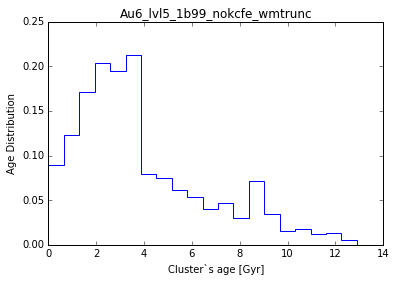

In [6]:
base_init, base_full, base_intermediate, base_old = get_mass_functions(simulation_list[0], plot_agedistribution=True)

Text(0.5, 1.0, 'Au6_lvl5_1b99_nokcfe_wmtrunc')

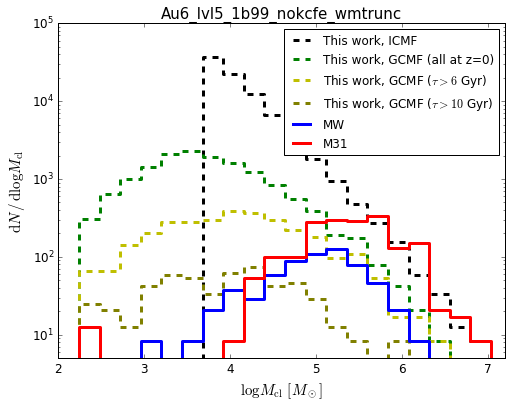

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

ax.step(marray_gcmf[:-1], base_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='This work, ICMF')
ax.step(marray_gcmf[:-1], base_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='This work, GCMF (all at z=0)')
ax.step(marray_gcmf[:-1], base_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'This work, GCMF ($\tau > 6$ Gyr)')
ax.step(marray_gcmf[:-1], base_old, where='post',c='olive', linestyle='dashed', linewidth = 3, label=r'This work, GCMF ($\tau > 10$ Gyr)')
ax.step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='b', label='MW')
ax.step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='r', label='M31')
ax.set_xlim(2,7.2)
ax.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
ax.set(ylim=(5e0,1e5), yscale= 'log')
ax.set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax.tick_params(labelsize=12)
ax.legend(loc='upper right', fontsize=12)
ax.set_title(simulation_list[0], fontsize=15)

In [21]:
initial_population =[]
full_population = []
intermediate_population = []
old_population = []

In [22]:
for sim in simulation_list:
    init, full, intermediate, old = get_mass_functions(sim)
    initial_population.append(init)
    full_population.append(full)
    intermediate_population.append(intermediate)
    old_population.append(old)

galrad= 0.02139289975166321
Found 167521 stars.
Maximum initial mass 6.24e+07 Msun
Maximum present-day mass 3.45e+07 Msun
Problematic stars with clusters 1169
That`s 1.207% of stars with clusters
galrad= 0.02139289975166321
Found 167521 stars.
Maximum initial mass 6.24e+07 Msun
Maximum present-day mass 3.45e+07 Msun
Problematic stars with clusters 1169
That`s 1.207% of stars with clusters


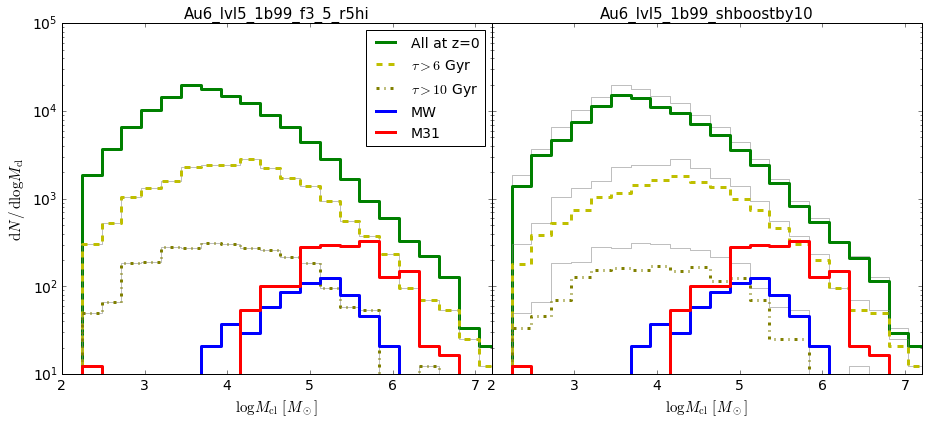

In [24]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(13,6))

for i,mf in enumerate(full_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], full_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='g', linewidth=3, label='All at z=0')

for i,mf in enumerate(intermediate_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], intermediate_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='y', linewidth=3, linestyle='--', label=r'$\tau > 6$ Gyr')
  
for i,mf in enumerate(old_population):
  # if((i+1)%2 == 0):
  ax[i].step(marray_gcmf[:-1], old_population[0], where='post', c='grey', linewidth=0.5)
  ax[i].step(marray_gcmf[:-1], mf, where='post', c='olive', linewidth=3, linestyle='-.', label=r'$\tau > 10$ Gyr')

for i in range(2):
  ax[i].step(marray_gcmf[:-1], mw_mass_function, where='post', linewidth=3, c='b', label='MW')
  ax[i].step(marray_gcmf[:-1], m31_mass_function, where='post', linewidth=3, c='r', label='M31')
  ax[i].set_xlim(2,7.2)
  ax[i].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=15)
  ax[i].tick_params(labelsize=14)
  ax[i].set_title(simulation_list[i], fontsize=15)

ax[0].set(ylim=(1e1,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=15)
ax[0].legend(loc='upper right', fontsize=14)

plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig('plots/shockshighboost_gcmf_compare.pdf')

In [25]:
all_init, all_full, all_intermediate, all_old = get_mass_functions(simulation_list[1], age_intermediate=6., age_old=10.)
inner_init, inner_full, inner_intermediate, inner_old = get_mass_functions(simulation_list[1], outer_radius=3., age_intermediate=6., age_old=10.)
intermediate_init, intermediate_full, intermediate_intermediate, intermediate_old = get_mass_functions(simulation_list[1], inner_radius=3., outer_radius=9., age_intermediate=6., age_old=10.)
outer_init, outer_full, outer_intermediate, outer_old = get_mass_functions(simulation_list[1], inner_radius=9., age_intermediate=6., age_old=10.)

/storage/home/can35/can35007/pylib/gadget_subfind.py:443: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('int64'):
/storage/home/can35/can35007/pylib/gadget_snap.py:702: H5pyDeprecationWarning: Using astype() as a context manager is deprecated. Slice the returned object instead, like: ds.astype(np.int32)[:10]
  with dset.astype('uint64'):


galrad= 0.02139289975166321
Found 167521 stars.
Maximum initial mass 6.24e+07 Msun
Maximum present-day mass 3.45e+07 Msun
Problematic stars with clusters 1169
That`s 1.207% of stars with clusters
galrad= 0.02139289975166321
Found 167521 stars.
Maximum initial mass 4.05e+07 Msun
Maximum present-day mass 2.25e+07 Msun
Problematic stars with clusters 1169
That`s 3.918% of stars with clusters
galrad= 0.02139289975166321
Found 167521 stars.
Maximum initial mass 6.24e+07 Msun
Maximum present-day mass 3.45e+07 Msun
Problematic stars with clusters 1169
That`s 2.694% of stars with clusters
galrad= 0.02139289975166321
Found 167521 stars.
Maximum initial mass 9.86e+06 Msun
Maximum present-day mass 5.52e+06 Msun
Problematic stars with clusters 1169
That`s 4.956% of stars with clusters


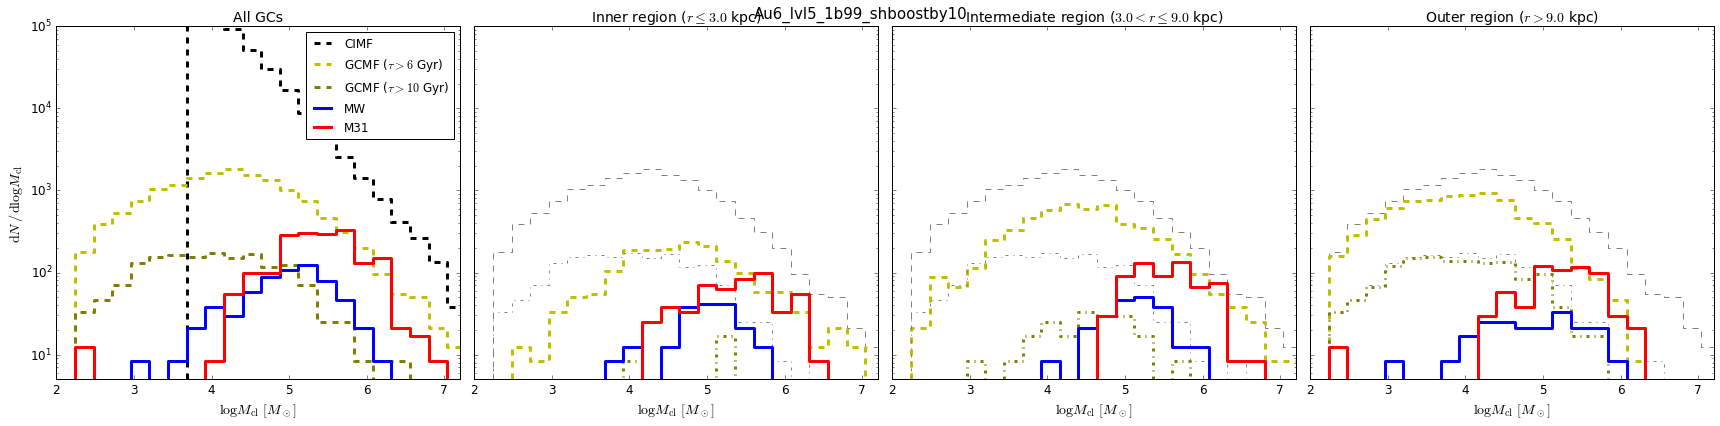

In [26]:
fig, ax = plt.subplots(1,4, figsize=(24,6), sharey=True)

ax[0].step(marray_gcmf[:-1], all_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[0].step(marray_gcmf[:-1], all_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[0].step(marray_gcmf[:-1], all_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[0].step(marray_gcmf[:-1], all_old, where='post',c='olive', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[0].step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[0].step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[0].set_title('All GCs', fontsize=14)
ax[0].set_xlim(2,7.2)
ax[0].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[0].tick_params(labelsize=12)

# ax[1].step(marray_gcmf[:-1], inner_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[1].step(marray_gcmf[:-1], inner_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[1].step(marray_gcmf[:-1], all_intermediate, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
ax[1].step(marray_gcmf[:-1], inner_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[1].step(marray_gcmf[:-1], all_old, where='post',c='gray', linestyle='dashdot', linewidth = 1, label=r'GCMF ($\tau > 10$ Gyr)')
ax[1].step(marray_gcmf[:-1], inner_old, where='post',c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[1].step(marray_gcmf[:-1], mw_inner_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[1].step(marray_gcmf[:-1], m31_inner_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[1].set_title(r'Inner region ($r \leq 3.0$ kpc)', fontsize=14)
ax[1].set_xlim(2,7.2)
ax[1].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[1].tick_params(labelsize=12)

# ax[2].step(marray_gcmf[:-1], intermediate_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[2].step(marray_gcmf[:-1], intermediate_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[2].step(marray_gcmf[:-1], all_intermediate, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
ax[2].step(marray_gcmf[:-1], intermediate_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[2].step(marray_gcmf[:-1], all_old, where='post',c='gray', linestyle='dashdot', linewidth = 1, label=r'GCMF ($\tau > 10$ Gyr)')
ax[2].step(marray_gcmf[:-1], intermediate_old, where='post',c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[2].step(marray_gcmf[:-1], mw_intermediate_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[2].step(marray_gcmf[:-1], m31_intermediate_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[2].set_title(r'Intermediate region ($3.0 < r \leq 9.0$ kpc)', fontsize=14)
ax[2].set_xlim(2,7.2)
ax[2].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[2].tick_params(labelsize=12)

# ax[3].step(marray_gcmf[:-1], outer_init, where='post',c='k', linestyle='dashed', linewidth = 3, label='CIMF')
# ax[3].step(marray_gcmf[:-1], outer_full, where='post',c='g', linestyle='dashed', linewidth = 3, label='GCMF (all at z=0)')
ax[3].step(marray_gcmf[:-1], all_intermediate, where='post',c='gray', linestyle='dashed', linewidth = 1, label=r'GCMF ($\tau > 6$ Gyr)')
ax[3].step(marray_gcmf[:-1], outer_intermediate, where='post',c='y', linestyle='dashed', linewidth = 3, label=r'GCMF ($\tau > 6$ Gyr)')
ax[3].step(marray_gcmf[:-1], all_old, where='post',c='gray', linestyle='dashdot', linewidth =1, label=r'GCMF ($\tau > 10$ Gyr)')
ax[3].step(marray_gcmf[:-1], outer_old, where='post',c='olive', linestyle='dashdot', linewidth = 3, label=r'GCMF ($\tau > 10$ Gyr)')
ax[3].step(marray_gcmf[:-1], mw_outer_mass_function, where='post',linewidth=3, c='b', label='MW')
ax[3].step(marray_gcmf[:-1], m31_outer_mass_function, where='post',linewidth=3, c='r', label='M31')
ax[3].set_title(r'Outer region ($r > 9.0$ kpc)', fontsize=14)
ax[3].set_xlim(2,7.2)
ax[3].set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=14)
ax[3].tick_params(labelsize=12)


ax[0].set(ylim=(5e0,1e5), yscale= 'log')
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=14)
ax[0].legend(loc='upper right', fontsize=12)
plt.tight_layout()
fig.suptitle(simulation_list[1], fontsize=15)
plt.savefig('plots/shhighboost_gcmf_radialbins.pdf')